# Gaussian Mixture Model (GMM) Implementation

# Imports

In [1]:
import os
import numpy as np
import pandas as pd

from scipy.stats import multivariate_normal as m_norm

import matplotlib.pyplot as plt
plt.style.use('default')
import seaborn as sns
sns.set_palette('deep')

from IPython.display import clear_output
import time 

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Gaussian Mixture Model

In [2]:
# READING DATA
data = np.genfromtxt('../data/clustering_data.csv', delimiter=',')
print('Shape:', data.shape)
X = data
X[:5,:]


Shape: (100, 2)


array([[-9.32426926, -8.52455014],
       [-4.8028932 ,  4.56839053],
       [-9.15191329, -7.23560011],
       [ 6.63140636,  6.88571356],
       [ 5.8005503 ,  7.15408237]])

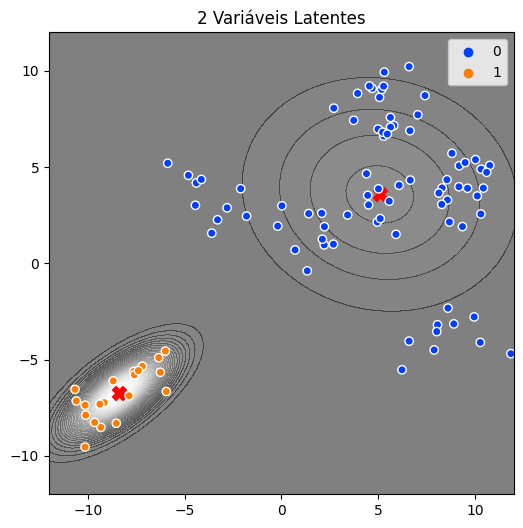

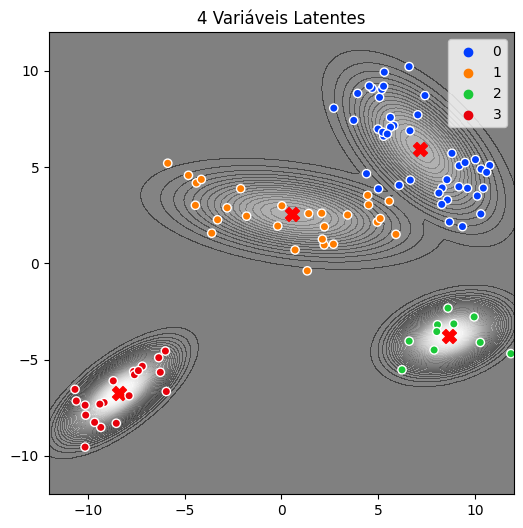

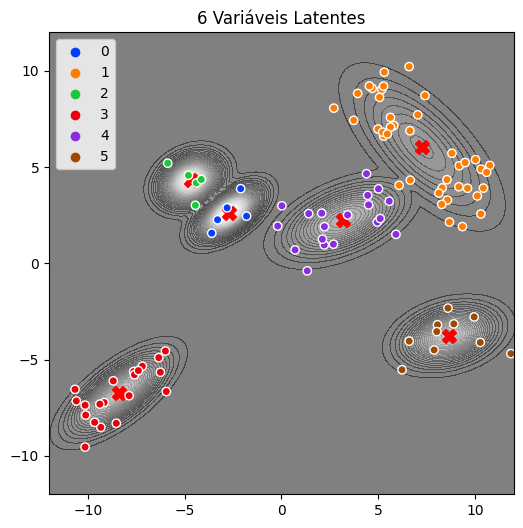

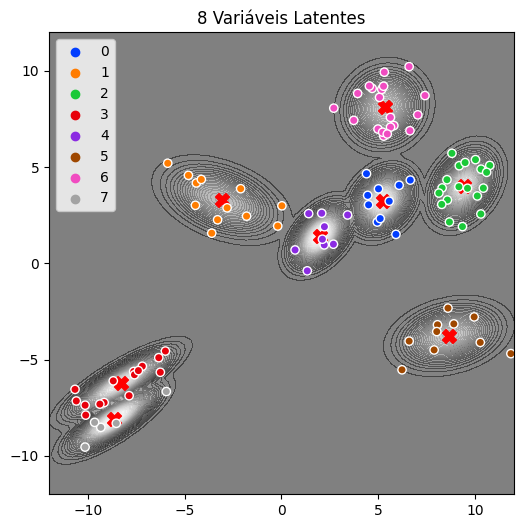

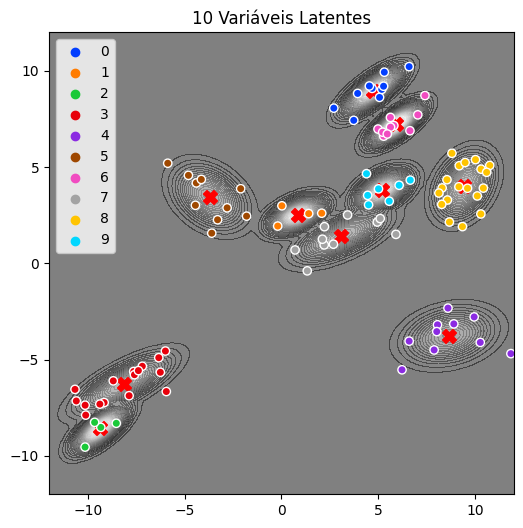

In [3]:
N = X.shape[0]
D = X.shape[1]

for K in [2, 4, 6, 8, 10]:
    
    np.random.seed(65493)
    # SETTING PARAMETERS
    alphas = np.ones(shape=(K))
    mu_0 = X.mean(axis=0)
    S_0 = (1 / K**(2/D)) * np.cov(X.T)
    v_0 = D + 2
    k_0 = 0.01
    pi = np.ones(K) / K

    # INITIALIZING MU AND SIGMA BASED ON RANDOM SUBSAMPLES
    mu = np.zeros(shape=(K, 2))
    sigma = np.zeros(shape=(K, D, D))
    for k in range(K):
        sample_X = X[np.random.choice(X.shape[0], K + 10), :]
        mu[k] = sample_X.mean(axis=0)
        sigma[k] = np.cov(sample_X.T)

    # EM ALGORITHM
    for i in range(100):

        # EXPECTATION
        r = np.zeros(shape=(X.shape[0], K))
        for k in range(K):
            num = pi[k] * m_norm.pdf(X, mu[k], sigma[k])
            
            denom = np.sum(
                [pi[j] * m_norm.pdf(X, mu[j], sigma[j]) for j in range(K)],
                axis=0
            )
            r[:, k] = num / denom

        # MAXIMIZATION
        X_bar = np.zeros(shape=(K, D))
        for k in range(K):
            # COMPUTING pi_k
            pi[k] = (alphas[k] - 1 + np.sum(r[:, k])) / (N - K + np.sum(alphas))
            
            # COMPUTING X_bar_k
            X_bar[k, :] = np.sum(r[:, k].reshape(-1, 1) * X, axis=0) / np.sum(r[:, k])
            
            # COMPUTING mu_k
            mu[k] = ((k_0 * mu_0) + X_bar[k] * np.sum(r[:, k]) / (k_0 + np.sum(r[:, k])))

            # COMPUTING sigma_k
            S_k = 0
            for j in range(X.shape[0]):
                X_minus_mean = X[[j]].reshape(-1, 1) - X_bar[k, :].reshape(-1, 1)
                S_k += r[j, k] * (X_minus_mean @ X_minus_mean.T)
            num_1 = S_0 + S_k
            num_2 = ((k_0 * np.sum(r[:, k]))/(k_0 + np.sum(r[:, k]))) * (X_bar[k, :] - mu_0).reshape(-1, 1) @ (X_bar[k, :]-mu_0).reshape(-1, 1).T
            denom = v_0 + D + 2 + np.sum(r[:, k])
            sigma[k] = (num_1 + num_2) / denom

    # PLOT RESULT
    dim = 100
    x = np.linspace(-12, 12, dim)
    y = np.linspace(-12, 12, dim)

    x, y = np.meshgrid(x, y)
    x, y = x.flatten(), y.flatten()

    Z = np.zeros(shape=(x.shape[0], K))
    for k in range(K):
        Z[:, k] = m_norm.pdf(np.array([x, y]).T, mu[k], sigma[k])

    x, y = x.reshape(dim, dim), y.reshape(dim, dim)
    Z = Z.max(axis=1).reshape(dim, dim)

    plt.figure(figsize=(6, 6))
    plt.title(f'{K} Variáveis Latentes')
    plt.contourf(x, y, Z, 50, cmap='Greys_r', alpha=0.5, zorder=-1)
    plt.scatter(
        mu[:, 0], mu[:, 1], 
        marker='X', 
        c='red', 
        s=100
    )

    sns.scatterplot(
        X[:, 0], X[:, 1], 
        hue=r.argmax(axis=1), 
        palette='bright', 
        linewidth=1
    )

    plt.show()
